In [ ]:
!gdown 1Wq5IEH-zKjxnIdDX29CVPVvrx0SeeulS
!7z x data.7z
!rm data.7z

Downloading...
From: https://drive.google.com/uc?id=1Wq5IEH-zKjxnIdDX29CVPVvrx0SeeulS
To: /content/data.7z
100% 797M/797M [00:20<00:00, 39.3MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 796922864 bytes (761 MiB)

Extracting archive: data.7z
--
Path = data.7z
Type = 7z
Physical Size = 796922864
Headers Size = 839
Method = LZMA2:26
Solid = +
Blocks = 1

  0%      0% 6 - data/bias/all_data.csv                                 1% 6 - data/bias/all_data.csv                                 2% 6 - data/bias/all_data.csv                                 3% 6 - data/bias/all_

In [ ]:
import numpy as np
import pandas as pd
from keras import models, layers, callbacks, optimizers, utils, losses, metrics
from keras.preprocessing import text

In [ ]:
train_df = pd.read_csv("./data/toxic/train.csv")

test_data_df = pd.read_csv("./data/toxic/test.csv")
test_labels_df = pd.read_csv("./data/toxic/test_labels.csv")
test_df= pd.merge(test_data_df, test_labels_df, on="id").query("toxic != -1")

In [ ]:
classes = train_df.columns[2:]

X_train = train_df["comment_text"].fillna("missing_text").values
y_train = train_df[classes].values

X_test = test_df["comment_text"].fillna("missing_text").values
y_test = test_df[classes].values

In [ ]:
VOCAB_SIZE = 20000
SEQ_LEN = 224

tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_tokenized = utils.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQ_LEN)
X_test_tokenized = utils.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQ_LEN)

In [ ]:
model = models.Sequential(
    [
        layers.Input(shape=(SEQ_LEN,)),
        layers.Embedding(VOCAB_SIZE, 128),
        layers.Bidirectional(layers.LSTM(50, return_sequences=True)),
        layers.GlobalMaxPool1D(),
        layers.Dropout(0.1),
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(6, activation="sigmoid"),
    ]
)

model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=metrics.BinaryAccuracy(),
)

In [ ]:
checkpoint_callback = callbacks.ModelCheckpoint(
    "./checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

earlystopping_callback = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=20
)

history = model.fit(
    X_train_tokenized,
    y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.1,
    callbacks=[checkpoint_callback, earlystopping_callback],
)

Epoch 1/3
2242/2244 [============================>.] - ETA: 0s - loss: 0.0688 - binary_accuracy: 0.9777
Epoch 1: val_loss improved from inf to 0.05034, saving model to ./checkpoints


2244/2244 [==============================] - 76s 30ms/step - loss: 0.0688 - binary_accuracy: 0.9778 - val_loss: 0.0503 - val_binary_accuracy: 0.9814
Epoch 2/3
2244/2244 [==============================] - ETA: 0s - loss: 0.0452 - binary_accuracy: 0.9832
Epoch 2: val_loss improved from 0.05034 to 0.04747, saving model to ./checkpoints


2244/2244 [==============================] - 54s 24ms/step - loss: 0.0452 - binary_accuracy: 0.9832 - val_loss: 0.0475 - val_binary_accuracy: 0.9828
Epoch 3/3
2243/2244 [============================>.] - ETA: 0s - loss: 0.0398 - binary_accuracy: 0.9848
Epoch 3: val_loss did not improve from 0.04747
2244/2244 [==============================] - 43s 19ms/step - loss: 0.0398 - binary_accuracy: 0.9848 - val_loss: 0.0491 - val_binary_accuracy: 0.9826


In [ ]:
from sklearn.metrics import auc, roc_curve, RocCurveDisplay, classification_report

# def roc_auc(predictions, target):
#     fpr, tpr, thresholds = roc_curve(target, predictions)
#     roc_auc = auc(fpr, tpr)
#     return roc_auc

scores = model.predict(X_test_tokenized)
# print("Auc: %.2f%%" % (roc_auc(scores, y_test)))

2000/2000 [==============================] - 17s 9ms/step


In [ ]:
scores_bin = [1 if score[0] >= 0.5 else 0 for score in scores]
print(classification_report(y_test[:, 0], scores_bin))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     57888
           1       0.56      0.85      0.67      6090

    accuracy                           0.92     63978
   macro avg       0.77      0.89      0.81     63978
weighted avg       0.94      0.92      0.93     63978



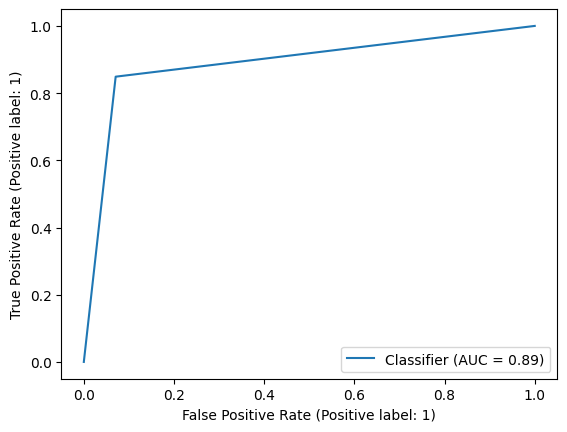

In [ ]:
RocCurveDisplay.from_predictions(y_test[:, 0], scores_bin)

In [ ]:
model.evaluate(X_test_tokenized, y_test)

1870/2000 [===========================>..] - ETA: 1s - loss: 0.0749 - binary_accuracy: 0.9694